# Introduction to CNN Keras - Acc 0.997 (top 8%) 
### **Yassine Ghouzam，博士**
#### 18/07/2017

* **1. 简介**
* **2. 数据预处理**
    * 2.1 加载数据
    * 2.2 检查空值和缺失值
    * 2.3 规范化
    * 2.4 重塑
    * 2.5 标签编码
    * 2.6 分裂训练和条件集
* **3. CNN**
    * 3.1 定义模型
    * 3.2 设置优化器和退火器
    * 3.3 数据增强
* **4. 评估模型**
    * 4.1 培训和验证曲线
    * 4.2 混淆矩阵
* **5. 预测和提交**
    * 5.1 预测并提交结果

# 1.简介
这是一个5层序列卷积神经网络，用于在MNIST数据集上训练的数字识别。我选择使用keras API（Tensorflow后端）构建它，这非常直观。首先，我将准备数据（手写数字图像）然后我将专注于CNN建模和评估。

我在2小时30分的单CPU（i5 2500k）上训练了CNN，达到了99.671％的准确率。 对于那些具有大于等于3.0 capabilites的GPU（从GTX 650到最新的GPU）用户，可以使用带有keras的tensorflow-gpu，计算会快得多!!!

**出于计算原因，我将步数（时期）设置为2，如果要达到99 +％的精度，则将其设置为30。**

本笔记本主要包含三个部分：

* 数据准备
* CNN建模和评估
* 结果预测和提交

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau


sns.set(style='white', context='notebook', palette='deep')

Using TensorFlow backend.


# 2. 数据预处理
## 2.1 加载数据

In [2]:
# Load the data（加载数据）
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

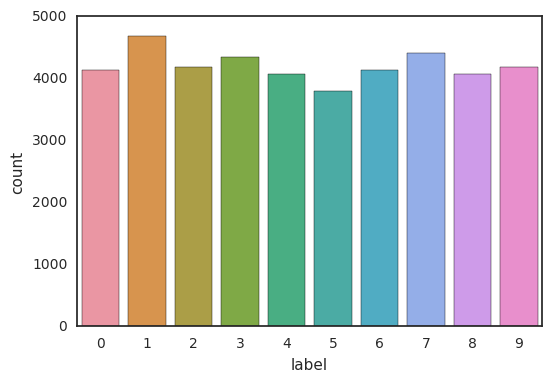

In [3]:
Y_train = train["label"]

# Drop 'label' column （删除【label】列）
X_train = train.drop(labels = ["label"],axis = 1) 

# free some space （释放空间）
del train 

g = sns.countplot(Y_train)

Y_train.value_counts()

我们用相似的10种分类

## 2.2 检查空值和缺失值

In [4]:
# Check the data（检查数据）
X_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [5]:
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

我检查是否有损坏的图像（里面缺少值）。

训练数据集和测试数据集中没有缺失值，所以我们可以放心地继续前进。

## 2.3 正则化

我们执行灰度标准化以减少照明差异的影响。

此外，CNN在[0..1]数据上比在[0..255]上收敛得更快。

In [6]:
# Normalize the data （正则化数据）
X_train = X_train / 255.0
test = test / 255.0

## 2.3 Reshape（改变数据结构）

In [7]:
# Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1) （重塑三维图像）
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

训练和测试图像（28px x 28px）已存入pandas.Dataframe作为784个值的1D向量，我们将所有数据重新整形为28x28x1的3D矩阵。

Keras最后需要一个与通道相对应的额外尺寸。MNIST图像是灰度缩放的，因此它只使用一个通道。对于RGB图像，有3个通道，我们将784px向量重新整形为28x28x3的3D矩阵。

## 2.5 标签编码

In [8]:
# Encode labels to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0]) （将标签编码到独热码）
Y_train = to_categorical(Y_train, num_classes = 10)

标签是从0到9的10位数字。我们需要将标签编码为一个独热码（例如：2 $->$ [0,0,1,0,0,0,0,0,0,0]）。

## 2.6 Split training and valdiation set 

In [9]:
# Set the random seed（设置随机种子）
random_seed = 2

In [10]:
# Split the train and the validation set for the fitting（为fit划分训练集和验证）
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=random_seed)

我选择将训练集分成两部分：一小部分（10％）成为验证集，模型评估，其余部分（90％）用于训练模型。

由于我们有42000个平衡标签的训练图像（参见2.1加载数据），因此随机分割训练集不会导致某些标签在验证集中过度表示。小心使用一些不平衡的数据集，简单的随机拆分可能会导致验证过程中的评估不准确。

为避免这种情况，您可以在train_test_split函数中使用stratify = True选项（**仅适用于> = 0.17 sklearn版本**）。

通过可视化图像和查看标签，我们可以更好地了解其中一个样本。

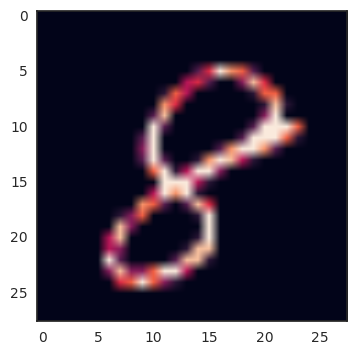

In [11]:
# 一些样本
g = plt.imshow(X_train[0][:,:,0])

# 3. CNN
## 3.1 定义模型

我使用了Keras Sequential API，您只需要从输入开始一次添加一个图层。

第一个是卷积（Conv2D）层，它就像一组可学习的过滤器。我选择为前两个conv2D层设置32个滤波器，为最后两个conv2D层设置64个滤波器。每个滤波器使用内核过滤器转换图像的一部分（由内核大小定义）。内核过滤器矩阵应用于整个图像。过滤器可以看作是图像的变换。



CNN可以隔离这些变换图像（特征图）中无处不在的特征。

CNN中的第二个重要层是池化（MaxPool2D）层。该层仅用作下采样过滤器。它查看每2个相邻像素并选择最大值(**译者注：如下图，中2x2最大池化**）。这些用于降低计算成本，并且在某种程度上还减少过度拟合。我们必须选择池化大小（即每次合并的区域大小），更多的池化维度更高，更多的下采样是重要的。
![pool](img/pool.webp)

结合卷积和池化层，CNN能够结合局部特征并学习图像的更多全局特征。

Dropout是一种正则化方法，其中对于每个训练样本，层中的一部分节点被随机忽略（将它们的wieghts设置为零）。这会随机丢弃网络的属性并迫使网络以分布式方式学习功能，该技术还改进了泛化并减少了过度拟合。

'relu'是整流器（激活函数max(0,x)）,整流器激活功能用于向网络添加非线性。

Flatten图层用于将最终要素图转换为单个1D向量。需要进行平坦化步骤，以便在一些卷积层或者maxpool层之后可以使用全连接层。它结合了先前卷积层的所有已发现的局部特征。

最后，我使用了两个全连接（密集）层中的特征，这些层只是人工神经网络（ANN）分类器。在最后一层（Dense(10, activation = "softmax")），净输出每个类的概率分布。

In [12]:
# Set the CNN model （设置模型）
# my CNN architechture is In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out

model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

## 3.2 设置优化器和衰减器
将图层添加到模型后，我们需要设置评价函数，损失函数和优化算法。

我们定义损失函数来衡量我们的模型在具有已知标签的图像上执行得有多糟糕。它是未成熟标签与预测标签之间（**译者注：模型预测的标签和真实的标签之间**）的错误率。我们使用特定形式进行分类分类（大于2个分类），称为“categorical_crossentropy”。

最重要的功能是优化器。该函数将迭代地改进参数（卷积核的权重，神经元的权重和偏差......）以便最小化损失。

我选择了RMSprop（默认值），它是一个非常有效的优化器。 RMSProp更新以非常简单的方式调整Adagrad方法，以尝试降低其积极的，单调递减的学习速率。我们也可以使用Stochastic Gradient Descent（'sgd'）优化器，但它比RMSprop慢。

评价函数“准确度”用于评估我们的模型的性能。此度量函数类似于损失函数，但在训练模型时不使用度量评估的结果（仅用于评估）。

In [13]:
# Define the optimizer （定义优化器）
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

In [14]:
# Compile the model （编译模型）
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

为了使优化器收敛得更快并且最接近损失函数的全局最小值，我使用了学习速率（LR）的衰减方法。

LR是优化器遍历“损失前景”的步长。 LR越高，步长越大，收敛越快。然而，高LR的采样非常差，优化器可能会陷入局部最小值。

最好在训练期间降低学习率，以有效地达到损失函数的全局最小值。

为了保持高LR的快速计算时间的优势，我每X步（动态）动态地减少LR，这取决于是否有必要（当精度没有提高时）。

使用Keras.callbacks的ReduceLROnPlateau函数，如果在3次迭代之后精度没有提高，我选择将LR（学习率）减半。

In [15]:
# Set a learning rate annealer （设置学习率衰减）
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [16]:
epochs = 10 # Turn epochs to 30 to get 0.9967 accuracy （将epochs变为30以获得0.9967的准确度）
batch_size = 86

## 3.3 数据增强

为了避免过度拟合问题，我们需要人工扩展我们的手写数字数据集。我们可以使您现有的数据集更大，这个想法是通过微小的变换来改变训练数据，以再现当有人写数字时发生的变化。

例如，数字不居中
规模不一样（有些人用大/小数字写）
图像旋转......

在保持标签相同的同时以改变阵列表示的方式改变训练数据的方法被称为数据增强技术。人们使用的一些流行的增强是灰度，水平翻转，垂直翻转，随机作物，颜色抖动，翻译，旋转等等。

通过将这些转换仅应用于我们的训练数据，我们可以轻松地将训练样例的数量增加一倍或三倍，并创建一个非常强大的模型。

改进很重要：
- 没有数据增加，我获得了98.114％的准确率
- 通过数据增强，我达到了99.67％的准确率

In [17]:
# Without data augmentation i obtained an accuracy of 0.98114
#history = model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs, 
#          validation_data = (X_val, Y_val), verbose = 2)

In [18]:
# With data augmentation to prevent overfitting (accuracy 0.99286)（使用数据增强来防止过度拟合（准确度0.99286））

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

/home/lqm/anaconda3/lib/python3.5/site-packages/keras/preprocessing/image.py:648: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (37800, 28, 28, 1) (1 channels).
  ' (' + str(x.shape[self.channel_axis]) + ' channels).')


对于数据扩充，我选择：
- 随机旋转部分训练图像10度
- 随机缩放10％部分训练图像
- 水平移动图像宽度的10％随机移动
- 将图像垂直移动10％的高度
   
我没有应用vertical_flip或horizontal_flip，因为它可能导致错误分类对称数字，如6和9。

一旦我们的模型准备就绪，我们就适合训练数据集。

In [19]:
# Fit the model
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

Epoch 1/10
195s - loss: 0.4189 - acc: 0.8654 - val_loss: 0.0691 - val_acc: 0.9810
Epoch 2/10
198s - loss: 0.1375 - acc: 0.9586 - val_loss: 0.0394 - val_acc: 0.9886
Epoch 3/10
191s - loss: 0.1039 - acc: 0.9692 - val_loss: 0.0605 - val_acc: 0.9826
Epoch 4/10
198s - loss: 0.0905 - acc: 0.9738 - val_loss: 0.0353 - val_acc: 0.9914
Epoch 5/10
217s - loss: 0.0780 - acc: 0.9769 - val_loss: 0.0337 - val_acc: 0.9912
Epoch 6/10
237s - loss: 0.0747 - acc: 0.9784 - val_loss: 0.0338 - val_acc: 0.9907
Epoch 7/10
310s - loss: 0.0706 - acc: 0.9794 - val_loss: 0.0257 - val_acc: 0.9926
Epoch 8/10
276s - loss: 0.0694 - acc: 0.9800 - val_loss: 0.0264 - val_acc: 0.9914
Epoch 9/10
231s - loss: 0.0661 - acc: 0.9808 - val_loss: 0.0267 - val_acc: 0.9912
Epoch 10/10
148s - loss: 0.0695 - acc: 0.9807 - val_loss: 0.0214 - val_acc: 0.9933


# 4. 评估模型
## 4.1 训练和验证曲线

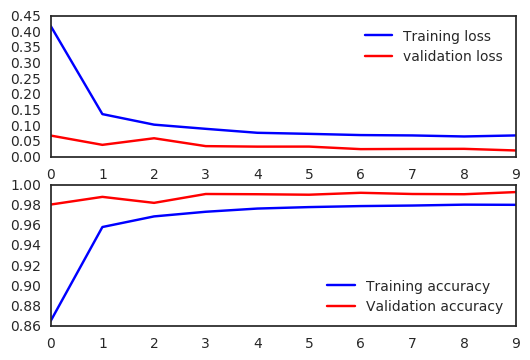

In [20]:
# Plot the loss and accuracy curves for training and validation  （绘制用于训练和验证的损失和准确度曲线）
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

以下代码用于绘制用于训练和验证的损失和准确度曲线。 因为，我在这台笔记本上设置了epochs = 2。
我将向您展示我从30次迭代（2h30）构建的模型中获得的训练和验证曲线



在2次迭代之后，该模型在验证数据集上达到几乎99％（98.7 +％）的准确度，`验证准确性大于训练期间的训练精度几乎耗费时间`(有误）。 这意味着我们的模型不会过度训练训练集。

我们的模型训练有素！



## 4.2 混淆矩阵

混淆矩阵对于查看模型缺陷非常有帮助。
我绘制了验证结果的混淆矩阵。

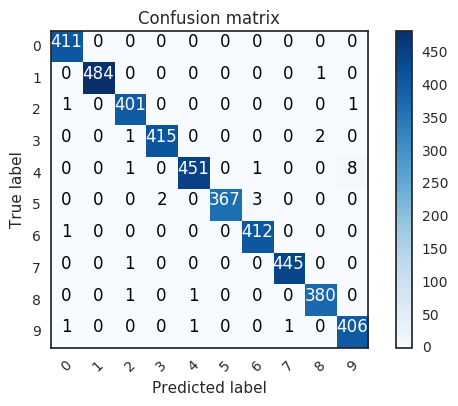

In [21]:
# Look at confusion matrix 

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 

在这里我们可以看到，考虑到验证集的大小（4200张图像），我们的CNN在所有数字上表现都很好，几乎没有错误。

然而，似乎我们的CNN在4上有一些小麻烦，嘿，被错误分类为9。当图像曲线平滑时很难捕捉到4和9之间的差异。

我们来调查错误。

我想看看最重要的错误。为此，我需要得出实际值的概率与结果中预测的概率之间的差异。

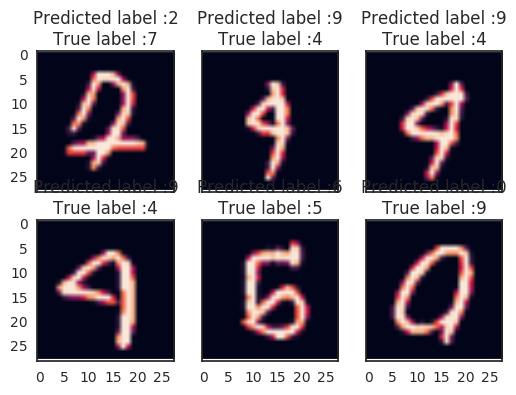

In [22]:
# Display some error results 

# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_val[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

最重要的错误也是最有趣的。

对于那六个案例，这个模型并不荒谬。其中一些错误也可以由人类有，特别是对于9来说非常接近4。最后的9也是非常误导的，对我来说似乎是0。

In [23]:
# predict results
results = model.predict(test)

# select the indix with the maximum probability
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")

In [24]:
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)

submission.to_csv("/home/lqm/kaggle_result/cnn_mnist_datagen3.csv",index=False)

**你发现这款笔记本很有用，或者你只是喜欢它，一些赞成会非常感激 - 这会让我保持动力:)**